### Importing requires libraries

In [34]:
pip install xgboost

     |████████████████████████████████| 1.7 MB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [35]:
import numpy as np
import pandas as pd
import os
import re
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
%matplotlib inline

### Reading csv into pandas dataframe

In [2]:
tweets = pd.read_csv('train.csv')
tweets.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
tweets.shape

(7613, 5)

#### Location wise values

In [5]:
tweets['location'].value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
Houma La                        1
Jersey                          1
The Web                         1
at my home                      1
Cheshire. London. #allover      1
Name: location, Length: 3341, dtype: int64

#### Keywords count

In [6]:
tweets['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

### Data Cleaning

In [7]:
cols_to_drop = ['location','id']

In [8]:
tweets = tweets.drop(cols_to_drop, axis = 1)

In [9]:
tweets["CleanText"] = tweets["text"].apply(lambda x: x.lower())
tweets.head()

,keyword,text,target,CleanText
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


In [10]:
tweets["CleanText"] = tweets["CleanText"].apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "",x))

In [11]:
def removeHTML(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

tweets["CleanText"] = tweets["CleanText"].apply(lambda x: removeHTML(x))

In [12]:
def removeEmojis(text):
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

tweets["CleanText"] = tweets["CleanText"].apply(lambda x: removeEmojis(x))

In [13]:
def RemovePunctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [14]:
tweets["CleanText"] = tweets["CleanText"].apply(lambda x: RemovePunctuation(x))

In [15]:
def RemoveASCII(text):
  return re.sub(r'[^\x00-\x7f]', "", text)

tweets["CleanText"] = tweets["CleanText"].apply(lambda x: RemoveASCII(x))

In [16]:
# def RemoveSpecial(text):
#     try:
#         return text.remove('#')
#     except:
#         return text

In [17]:
# tweets["CleanText"] = tweets["CleanText"].apply(lambda x: RemoveSpecial(x))

In [18]:
tweets.head(30)

,keyword,text,target,CleanText
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
5,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 closed in ...
6,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain causes flash floodin...
7,NaN,I'm on top of the hill and I can see a fire in...,1,im on top of the hill and i can see a fire in ...
8,NaN,There's an emergency evacuation happening now ...,1,theres an emergency evacuation happening now i...
9,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid that the tornado is coming to our area


#### There are 61 missing values in Keyword feature

In [19]:
features = ['keyword']
for feat in features : 
    print("The number of missing values in "+ str(feat)+" are "+str(tweets[feat].isnull().sum()))
    
    
    

The number of missing values in keyword are 61


### Analysis

In [20]:
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0]=8
plot_size[1]=6
plt.rcParams["figure.figsize"]=plot_size


6.0
4.0


##### target = 1 is when disaster occurs and target = 0 is when disaster does not occur

/Users/abhitejamandava/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

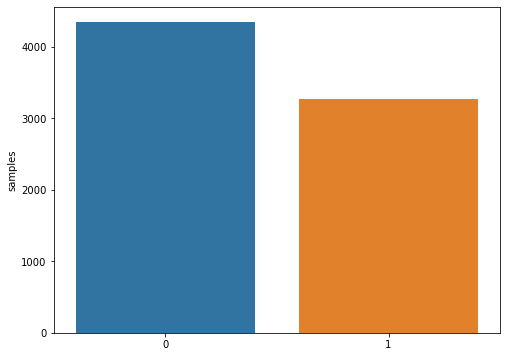

In [21]:
x=tweets.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [22]:
def _corpus(target):
    corpus=[] # document
    
    for x in tweets[tweets['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 20 artists>

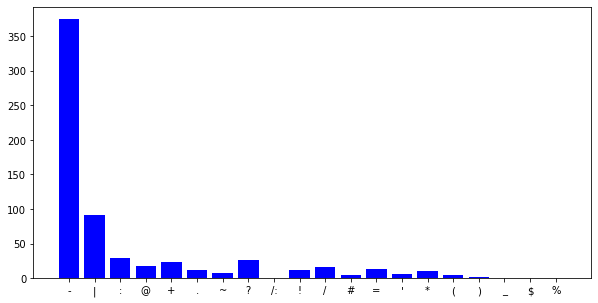

In [23]:
from collections import defaultdict
plt.figure(figsize=(10,5))
corpus=_corpus(0)
import string
d=defaultdict(int)
s = string.punctuation
for i in (corpus):
    if i in s:
        d[i]+=1
        
x,y=zip(*d.items())
plt.bar(x,y,color='blue')

In [24]:
#Observing the stop words like a, the, in, is etc
from nltk.corpus import stopwords
stop=set(stopwords.words('english')) 

In [25]:
from collections import  Counter
c=Counter(corpus)
m=c.most_common()
x=[]
y=[]
for w,c in m[:]:
    if (w not in stop):
        x.append(w)
        y.append(c)

In [26]:
# sns.barplot(x=y,y=x)

In [27]:

X_train, X_test, y_train, y_test = train_test_split(tweets['text'], tweets['target'], test_size=0.2)
X_train.head()

1230    Fire hazard associated with installation of no...
6400    Suicide bomber kills 15 in Saudi security site...
7175    THIS IS A ONE DIRECTION CONCERT NOT A WAR ZONE...
2227    The f$&amp;@ing things I do for #GISHWHES Just...
7129    #Earthquake #Sismo M 1.9 - 5km S of Volcano Ha...
Name: text, dtype: object

In [28]:
tfidf_vect = TfidfVectorizer()
X_train_vect = tfidf_vect.fit_transform(X_train)
X_test_vect = tfidf_vect.transform(X_test)

In [29]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect, y_train.values.ravel())

In [30]:
y_pred = rf_model.predict(X_test_vect)

In [31]:
precision = precision_score(y_test, y_pred)
print(f"Precision: {round(precision, 3)} Accuracy: {round((y_pred==y_test).sum()/len(y_pred), 3)}")







Precision: 0.841 Accuracy: 0.773


In [36]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
xgb_cl = xgb.XGBClassifier()
xg_model = xgb_cl.fit(X_train_vect, y_train.values.ravel())

preds = xg_model.predict(X_test_vect)
precision_xg = precision_score(y_test, preds)
print(f"Precision: {round(precision_xg, 3)} Accuracy: {round((preds==y_test).sum()/len(preds), 3)}")

Precision: 0.81 Accuracy: 0.773


<!-- Updating paper.md file with Random Forest Analysis and proofs -->